In [1]:
import numpy as np

# Problema del Page Rank

Il **PageRank** (PR) è un valore che rappresenta l'importanza di una pagina in un network tramite la misurazione della quantità e qualità delle pagine che presentano link ad essa.<br>
I co-fondatori di Google **Sergey Brin** e **Larry Page** concepirono PageRank nel 1997 come parte di un progetto di ricerca alla Stanford University.
<br><br>
Il web (o meglio, una sua porzione) viene rappresentato come un **grafo diretto**: i nodi sono pagine e un arco da una pagina all'altra indica un link tra di esse. <br>
L’algoritmo che calcola il PageRank non fornisce un “punteggio” assoluto, ma piuttosto una misura relativa della qualità di una pagina web rispetto a tutte le altre pagine nel grafo dei link. <br>
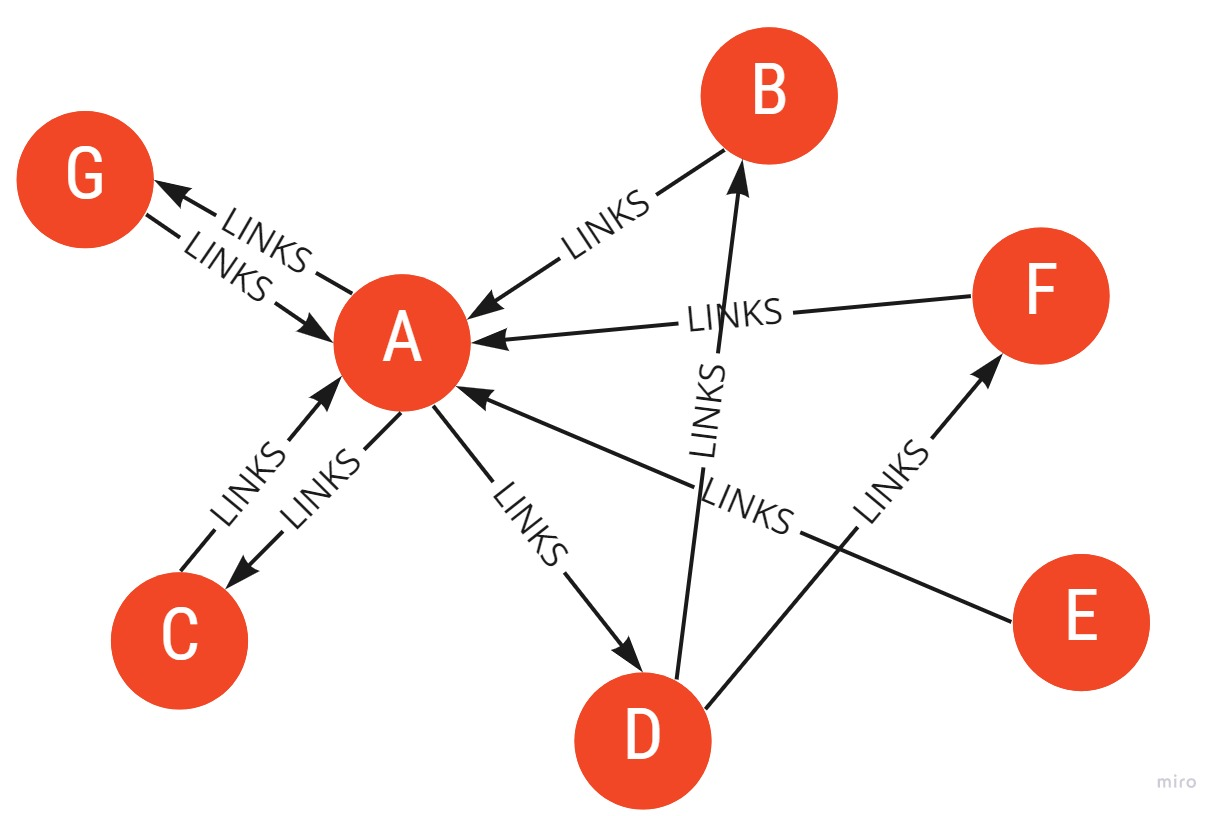

L'importanza di una pagina è legata alle sue connessioni (e non al suo contenuto) ed è trasferita alle pagine a cui essa punta. Il PR è dunque dato dalla somma delle frazioni di importanza delle pagine a cui esse puntano. <br>

---

Numerando le pagine da 1 a n, definiamo la **matrice di connettività G**, con:<br>
*G[i,j]* = 1 se c'è un link dalla pagina j alla pagina i<br>
*G[i,j]* = 0 altrimenti<br><br>
Indichiamo con <br>
*x[i]* l'importanza della pagina i;<br>
*c[j]* il numero di link che partono dalla pagina j;<br>
*r[i]* il numero di link che puntano alla pagina i;<br>
*p*, compreso tra 0 e 1, la percentuale di importanza che transita da una pagina all'altra (damping factor)<br> 
*D* matrice diagonale nXn contenente gli inversi di ogni c[i]<br>
*e* vettore colonna di dimensione n contentene 1 in ogni posizione


---
Costruiamo un sistema lineare nXn (sparso) la cui soluzione fornisce il PR delle singole pagine. Il sistema può essere scritto nella forma:<br>


> ( I - pGD ) x = (1-p)/n * e 

indichiamo con **A la matrice (I - pGD)** e con **b il vettore colonne (1-p)/n * e **. <br>
La soluzione **unica** del sistema Ax=b può essere determinata con **metodi diretti** (Gauss naive/pivoting) o **indiretti** (Gauss-Seidel, Jacobi)

---
In alternativa, possiamo costruire la matrice 


> Ap = p * G @ D + ((1-p)/n) * e @ e.T<br>

che risolve il sistema **x = Ap x**. Risolvere il sistema equivale a trovare l'autovettore di norma 1 unitaria corrispondente all'autovalore 1.<br>
Poichè la matrice Ap è **stocastica** (modifica di matrice sparsa, contenente valori tra 0 e 1, somma di ciascuna colonna uguale a 1) è possibile calcolare l'auovettore x relativo all'autovalore 1 (di massimo modulo) usando il **metodo delle potenze**.

















L'algoritmo qui utilizzato si compone dei seguenti passi (pipeline):


1.   Costruzione della matrice di connettività G relativa ad un URL
2.   Calcolo delle matrici A, Ap e del vettore colonna b
3.   Risoluzione del sistema lineare Ax=b e ricerca dell'autovettore di Ap.
4.   Per ogni soluzione, stampa della pagina più importante della rete
5.   Confronto dei risultati



# Metodi diretti

I **metodi diretti** per la risoluzione di sistemi lineari costruiscono l'esatta soluzione, in assenza di errori di arrotondamento, in un numero finito di passi. <br>
La soluzione *x* è ottenuta in un numero finito di passi mediante una successione (finita) di trasformazioni del problema iniziale in problemi equivalenti, cioè con la stessa soluzione x, ma con matrici dei coefficienti diversi.

---



Il metodo diretto più noto è quello delle **eliminazioni successive di Gauss**. L'algoritmo trasforma un generico sistema non singolare Ax=b in un sistema equivalente, cioè con la stessa soluzione, di forma triangolare Ux=c.<br>
Forniamo due versioni dell'algoritmo:


*   **MEG_naive** costruisce il sistema equivalente senza permutare l'ordine iniziale delle equazioni, ovvero delle righe, ma può bloccarsi senza terminare il processo quando al passo k-esimo trova un pivot nullo;
*   **MEG_pivoting** cerca ad ogni passo l'elemento pivot ed effettua scambi di righe. 



In [2]:
def MEG_naive(A: np.array, b: np.array):

    U = np.copy(A)
    c = np.copy(b)
    det = 1

    rows = np.size(U, 0)
    cols = np.size(U, 1)

    C = np.linalg.norm(A, np.inf)

    for k in range(cols-1):

        if U[k][k] == 0:
            print("Elemento nullo sulla diagonale")
            return U, c, None

        if abs(U[k][k]) < abs(np.finfo(float).eps * C):
            print("Warning! Possibile elemento nullo sulla diagonale")

        det *= U[k][k]  # aggiornamento del determinante

        for i in range(k+1, rows):
            moltiplicatore = U[i][k] / U[k][k]
            U[i, k:] = U[i, k:] - moltiplicatore * U[k, k:]
            c[i] = c[i] - moltiplicatore * c[k]

    # aggiornamento del determinante e controllo
    if abs(U[rows-1][cols-1]) < abs(np.finfo(float).eps * C):
        print("Warning! Il determinante potrebbe essere nullo")
    det *= U[rows-1][cols-1]

    return U, c, det

In [3]:
def MEG_pivoting(A: np.array, b: np.array):
 
    U = np.copy(A)
    c = np.copy(b)
    det = 1

    rows = np.size(U, 0)
    cols = np.size(U, 1)

    C = np.linalg.norm(A, np.inf)

    pivot = np.arange(cols)

    for k in range(cols-1):

        argmax = abs((U[k:rows, k])).argmax() + k
        maxElement = U[argmax][k]

        if argmax > k:
            U[[k, argmax]] = U[[argmax, k]]  # scambio di riga in U
            c[[k, argmax]] = c[[argmax, k]]  # scambio di riga in c
            # scambio indici in pivot
            pivot[k], pivot[argmax] = pivot[argmax], pivot[k]
            det = -det  # in caso di scambio di riga, il determinante cambia segno

        if U[k][k] == 0:
            print("Elemento nullo sulla diagonale")
            return U, c, None

        if abs(U[k][k]) < abs(np.finfo(float).eps * C):
            print("Warning! Possibile elemento nullo sulla diagonale")

        det *= U[k][k]  # aggiornamento del determinante

        for i in range(k+1, rows):
            moltiplicatore = U[i][k] / U[k][k]
            U[i, k:] = U[i, k:] - moltiplicatore * U[k, k:]
            c[i] = c[i] - moltiplicatore * c[k]
 

    # aggiornamento del determinante e controllo
    if abs(U[rows-1][cols-1]) < abs(np.finfo(float).eps * C):
        print("Warning! Il determinante potrebbe essere nullo")
    det *= U[rows-1][cols-1]


    return U, c, det, pivot


La soluzione di un sistema non singolare di forma triangolare superiore è pressocchè immediata. <br>
Con la funzione back_substitution è possibile calcolare la soluzione del sistema dopo aver applicato uno dei metodi di eliminazione di Gauss.

In [4]:
def back_substitution(A: np.array, b: np.array):

    n = np.size(A, 1)  # numero di righe di A
    x = np.zeros((n, 1))  # inizializza x ad un vettore colonna nullo

    x[n-1] = b[n-1] / A[n-1, n-1]

    for i in range(n-2, -1, -1):  # si procede all’indietro
        sommatoria = 0
        
        for j in range(i+1, n):
            sommatoria += float(A[i, j]) * float(x[j])

        x[i] = (b[i] - sommatoria) / A[i, i]

    return x

# Metodi iterativi





I **metodi iterativi** operano sempre e solo con gli elementi della matrice iniziale A, generano una successione infinita di vettori convergente, sotto opportune condizioni, alla soluzione cercata. <br>
I metodi iterativi, se convergenti, consentono di arrestare il processo iterativo non appena la precisione desiderata è stata raggiunta. Un metodo iterativo risulterà efficiente se raggiungerà la precisione desiderata (tolleranza) con un numero accettabile di iterazioni.

---



Il metodo di Jacobi consiste nel calcolare, nota un'approssimazione iniziale della soluzione, le successive approssimazioni tramite una relazione algebrica.<br>
Il metodo di Gauss-Seidel ha un procedimento analogo ma utilizza, nella determinazione di x[k], alcuni valori già calcolati.

In [5]:
def jacobi_decomposizione_ottimizzato(A, b, x0, toll, n_max, verbose=False):
    """
    Risoluzione di un sistema lineare Ax=b data un'approssimazione iniziale x0.
    L'algoritmo implementa il metodo iterativo di Jacobi usando la decomposizione 
    della matrice dei coefficienti A = D + C.

    :param A: matrice dei coefficienti
    :param b: vettore colonna dei termini noti
    :param x0: approssimazione iniziale
    :param toll: tolleranza, ovvero precisione relativa richiesta
    :param n_max: massimo numero di iterazioni
    :param verbose: se True, stampa informazioni sulle iterazioni
    :return: soluzione x, stima dell'errore, numero di iterazioni eseguite
    :rtype: np.array, float, int
    """

    # calcolo matrici D e C
    D = np.diag(np.diag(A))
    C = A - D

    # Inizializzazioni
    n_iter = 0
    x = np.copy(x0)

    # Matrici iterative
    B = np.dot(np.linalg.inv(D), b)
    c = np.dot(np.linalg.inv(D), C)

    # Processo iterativo
    while n_iter < n_max:
        x = B - np.dot(c, x0)

        stima_errore = np.linalg.norm(x-x0, np.inf) / np.linalg.norm(x, np.inf)
        if stima_errore <= toll:
            break
        x0 = np.copy(x)
        n_iter += 1
        if verbose:
            print("valore di x alla iterazione numero ",
                  n_iter, ", stima errore =", stima_errore)
            print(x.T)

    return x, stima_errore, n_iter


def gauss_seidel_decomposizione_ottimizzato(A, b, x0, toll, iter_max, verbose=False):
    """
    Risoluzione di un sistema lineare Ax=b data un'approssimazione iniziale x0.
    L'algoritmo implementa il metodo iterativo di Gauss Seidel usando la decomposizione 
    della matrice dei coefficienti A = L + U.

    :param A: matrice dei coefficienti
    :param b: vettore colonna dei termini noti
    :param x0: approssimazione iniziale
    :param toll: tolleranza, ovvero precisione relativa richiesta
    :param n_max: massimo numero di iterazioni
    :param verbose: se True, stampa informazioni sulle iterazioni
    :return: soluzione x, stima dell'errore, numero di iterazioni eseguite
    :rtype: np.array, float, int
    """

    # calcolo matrici L=lower e U=upper
    lower = np.tril(A)
    upper = A - lower

    # Inizializzazioni
    n_iter = 0
    x = np.copy(x0)

    # Matrici iterative
    B = np.dot(np.linalg.inv(lower), b)
    c = np.dot(np.linalg.inv(lower), upper)

    # Processo iterativo
    while n_iter < iter_max:
        x = B - np.dot(c, x0)
        n_iter += 1
        stima_errore = np.linalg.norm(x-x0, np.inf) / np.linalg.norm(x, np.inf)
        if stima_errore <= toll:
            break
        x0 = np.copy(x)

    return x, stima_errore, n_iter

# Metodo delle potenze

In [6]:
def metodo_potenze(A: np.array, toll: float, n_iter_max: int, y0: np.array, verbose=False):
    """
    Calcolo dell’autovalore di modulo massimo e relativo autovettore.

    :param A: matrice di cui calcolare l’autovalore di modulo massimo
    :param toll: tolleranza, ovvero precisione relativa richiesta
    :param n_iter_max: numeri massimo di iterazioni
    :param y0: vettore iniziale per approssimare l’autovettore
    :param verbose: se True, stampa informazioni sulle iterazioni
    :return: autovalore di modulo massimo lambdaa, stima Errore, numero di iterazioni eseguite, autovettore realitivo a lambdaa
    :rtype: float, float, int, np.array
    """

    n_iter = 0
    stima_errore = 1.0
    lambdaa0 = 0.0

    while n_iter < n_iter_max and stima_errore >= toll:
        w = np.dot(A, y0)
        k = np.argmax(np.abs(w))

        lambdaa = w[k] / y0[k]
        stima_errore = abs(lambdaa-lambdaa0)/abs(lambdaa)
        lambdaa0 = lambdaa

        y = w / np.linalg.norm(w, ord=1)
        y0 = np.copy(y)
        n_iter += 1
        if verbose:
            print("n_iter =", n_iter, ", lambda =", lambdaa)
            print(y.T)

    return lambdaa, stima_errore, n_iter, y



# Algoritmo di generazione del sistema lineare

La funzione **pagerank(G, b)** genera le matrici A, Ap e il vettore b.
Le matrici sono costruite in modo che la soluzione **x** del sistema lineare **Ax=b** individui il page rank delle pagine in U a partire dalla matrice di connettività G.<br>
La matrice **Ap** permette di risolvere il problema del page rank come ricerca di autovettori associati all'autovalore **1** di **Ap**.

In [7]:
def pagerank(G: np.array, p: float):

    n = np.shape(G)[0] # numero di pagine = numero di righe o colonne di G

    G = G-np.diag(np.diag(G)) # eliminazione link autoreferenziali

    for i in range(n): # riempimento colonne nulle
        if(sum(G[:,i]) == 0):
            G[:,i] = 1
            G[i,i] = 0 

    delta = (1-p)/n # importanza minima
    e = np.ones((n,1)) # vettore colonna di tutti 1
    b = delta * e # costruzione b

    I = np.eye(n) # matrice identità nXn
    
    c = sum(G) # vettore riga somma degli elementi della colonna
    cInv = 1./c # operazione componente per componente
    D = np.diag(cInv) 

    # costruzione A e Ap
    A = I - p*(np.dot(G,D))
    Ap = p*np.dot(G,D)+delta*np.dot(e, e.T)

    return A, Ap, b


# Crawler

I crawler costituiscono uno dei componenti base dei motori di ricerca web: sono software che analizzano i conenuti di una rete in modo metodico e automatizzato. 
<br>
I crawler programmati per la ricerca di link tra pagine possono differenziarsi in base al modo in cui decidono quali link visitare e in che ordine, alla profondità di ricerca, alla frequenza di aggiornamento, al numero di ricerche effettuate in parallelo...
<br>
Nello specifico, findHTTP è implementato in modo da acquisire una copia testuale di una pagina web e identificare, in maniera "naive", i collegamenti ipertestuali all'interno di essa.

La funzione **findHTTP(root)** costruisce la lista contenente tutti i link trovati nella pagina root. 

In [8]:
import socket
import http
import re
import urllib.request
from urllib.error import HTTPError


def findHTTP(root: str):

    urls = []

    skips = ["whatsapp", "mailto", '.gif', '.jpg', '.jpeg', '.png', '.pdf', '.css', '.asp', '.mwc', '.ram', '.cgi',
             'lmscadsi', 'cybernet', 'w3.org', 'google', 'yahoo', 'scripts', 'netscape', 'shockwave', 'webex', 'fansonly']
    not_skips = ['http://', 'https://']

    try: # Prova ad aprire la pagina root
        with urllib.request.urlopen(root, timeout=5) as response:

            # Legge e codifica il codice html
            html = response.read()
            plaintext = html.decode('utf8', "ignore")

            # Cerca i link nella pagina aperta
            # Un link è individuato dal tag href
            links = re.findall("href=[\"\'](.*?)[\"\']", plaintext)
            links += (re.findall("HREF=[\"\'](.*?)[\"\']", plaintext))

            for link in links:
                # Rimuove l'ultimo '/' e toglie gli spazi da ogni link trovato                
                if len(link) > 1 and link[-1] == '/':
                    link = link[:-1]
                link.strip()

                # Controlla la validità del link
                if not any(word in link for word in skips) and any(word in link for word in not_skips):
                    urls.append(link)

    except (HTTPError, urllib.error.URLError, ConnectionResetError, http.client.InvalidURL) as err:
        print(root, " ERRORE: ", err)
    except socket.timeout:
        print("connection's timeout expired")

    return urls

# Surfer

La funzione **surfer(root, n)** utilizza il crawler implementato con findHTTP per generare la lista di link e costruisce la matrice di connetività **G** di dimensione ***n*X*n***  a partire dalla pagina root.<br>
In particolare, **G[i,j] = 1** se esiste un link dalla pagina **j** alla pagina **i**, **= 0** altrimenti.<br>


---


L'algoritmo è una libera traduzione in python della funzione surfer di Cleve Moler per MATLAB

In [9]:
def surfer(root, n):

    # Inizializzazioni
    U = []
    G = np.zeros((n, n))
    hashURL = []
    hashURL.append(hash(root))
    U.append(root)

    next_root_idx = 0
    j = 0

    for j in range(n):

        current_root = U[j]

        # Genera la lista di link
        pages = findHTTP(current_root)
        print("Page #", j, "=", U[j])

        for page in pages:
            hashPage = hash(page)
            try:
                # Controlla se la pagina è già presente in hashURL
                i = hashURL.index(hashPage) 
                if i != j and U[i] == page:
                    # Aggiunge un nuovo link alla matrice di incidenza G
                    G[i, j] = 1
            except ValueError:
                # Aggiunge un nuovo link ad U, se ce ne sono meno di n
                if next_root_idx < n-1:
                    next_root_idx += 1
                    hashURL.append(hashPage)
                    U.append(page)
                    G[next_root_idx, j] = 1

    return U, G


# **Grafico di connettività**
# **@author: Giorgio Angelo Esposito**

A partire dalle matrici G e U

In [ ]:
!pip install pyvis # Installare la libreria pyvis per rendere il grafo interattivo

In [11]:
from pyvis.network import Network
from IPython.core.display import display, HTML
import networkx as nx
import numpy as np

In [12]:
def make_graph(G,U):

    #aggiungere altri colori
    colors = np.array(["#856d67","#bf2f10","#35e30b","#4d7144","#2b97cd","#0a0ddd","#ac29bf","#812d69",
                      "#cda2c0","#d628a4","#ffffff","#000000","#666666","#f8f40c","#64620b","#b5b599",
                      "#21e2c2","#1d7264","#9dbab5","#806fa2","#352357","#d01fb9","#e887dc","#df1313",
                      "#bd900d","#164910","#137a08","#0ad259","#71d89a","#587c87","#083543","#1b6981",
                      "#5b567f","#7a2382","#c39cc7","#64216a","#b6afb7","#9d3361","#b86388","#ca2c70",
                      "#770a0a","#776f6f","#814141","#a14a4a","#670c0c","#b03838","#741717","#a55c5c"])
    
    graph = nx.from_numpy_matrix(G,create_using=nx.DiGraph())
    for node in graph.nodes:
      graph.nodes[node]['title'] = U[node]
      graph.nodes[node]['size'] = 50
      graph.nodes[node]['color'] = np.random.choice(colors)

    for u,v in graph.edges:
      graph.edges[u,v]['color'] = graph.nodes[u]['color']
    
    return graph


# Esecuzione script

Utilizzando l'algoritmo *surfer(G,n)*, consideriamo n pagine web estratte da un link *root* e calcoliamo il page rank associato alle pagine considerate. <br>
Il calcolo è effettuato utilizzando metodi diretti (Gauss Naive e Gauss Pivoting), metodi indiretti (Jacobi e Gauss-Sediel) e metodo delle potenze.

---



Le funzioni sono pronte per essere usate nello script. <br>Occorre impostare i valori delle variabili che parametrizzano il problema specifico: il link di partenza, il numero di pagine da analizzare, la tolleranza e il massimo numero di iterazioni degli algoritmi iterativi.

In [13]:
import time


root = "http://www.harvard.edu"
num_pages = 500
toll = np.finfo(float).eps
nMax = 500
x0 = np.full((num_pages, 1), 1/num_pages)

L'algoritmo del PR inizia con la generazione delle matrici **G** e **U**. <br>
Vengono ordinatamente stampati i link delle pagine individuate dall'algoritmo e il tempo totale di esecuzione della funzione **surfer(root, num_pages)**

In [14]:
start = time.time()
U, G = surfer(root, num_pages)
end = time.time()
print("Total surfer time =", end-start)

Page # 0 = http://www.harvard.edu
https://www.harvard.edu/xmlrpc.php  ERRORE:  HTTP Error 403: Forbidden
Page # 1 = https://www.harvard.edu/xmlrpc.php
Page # 2 = https://www.harvard.edu
Page # 3 = https://www.harvard.edu/homepage/feed
Page # 4 = https://www.harvard.edu/wp-json
Page # 5 = https://www.harvard.edu/wp-json/wp/v2/pages/6392
https://www.harvard.edu/xmlrpc.php?rsd  ERRORE:  HTTP Error 403: Forbidden
Page # 6 = https://www.harvard.edu/xmlrpc.php?rsd
Page # 7 = https://www.harvard.edu/wp-includes/wlwmanifest.xml
Page # 8 = https://www.harvard.edu/wp-json/oembed/1.0/embed?url=https%3A%2F%2Fwww.harvard.edu%2F
Page # 9 = https://www.harvard.edu/wp-json/oembed/1.0/embed?url=https%3A%2F%2Fwww.harvard.edu%2F&#038;format=xml
Page # 10 = https://www.harvard.edu/wp-content/plugins/waveplayer/assets/js/waveplayer.min.js
Page # 11 = https://www.harvard.edu/wp-content/themes/core/assets/js/dist/theme/vendor.min.js?ver=60f3f1cc9f6bc0816de94f7556fed954
Page # 12 = https://www.harvard.edu/wp-

In [15]:
print(U)

['http://www.harvard.edu', 'https://www.harvard.edu/xmlrpc.php', 'https://www.harvard.edu', 'https://www.harvard.edu/homepage/feed', 'https://www.harvard.edu/wp-json', 'https://www.harvard.edu/wp-json/wp/v2/pages/6392', 'https://www.harvard.edu/xmlrpc.php?rsd', 'https://www.harvard.edu/wp-includes/wlwmanifest.xml', 'https://www.harvard.edu/wp-json/oembed/1.0/embed?url=https%3A%2F%2Fwww.harvard.edu%2F', 'https://www.harvard.edu/wp-json/oembed/1.0/embed?url=https%3A%2F%2Fwww.harvard.edu%2F&#038;format=xml', 'https://www.harvard.edu/wp-content/plugins/waveplayer/assets/js/waveplayer.min.js', 'https://www.harvard.edu/wp-content/themes/core/assets/js/dist/theme/vendor.min.js?ver=60f3f1cc9f6bc0816de94f7556fed954', 'https://www.harvard.edu/wp-content/plugins/waveplayer/assets/fonts/fa-solid-900.woff2', 'https://www.harvard.edu/wp-content/plugins/waveplayer/assets/fonts/fa-brands-400.woff2', 'https://www.directory.harvard.edu', 'https://www.harvard.edu/a-to-z', 'https://www.harvard.edu/program

In [16]:
print(G)

[[0. 0. 0. ... 1. 0. 1.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Visualizziamo la **matrice di connettività G** con un grafico **raster** (griglia) usando il comando *imshow* di *matplotlib*.<br>
*   0 = viola
*   1 = giallo


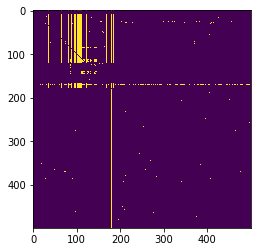

In [17]:
import matplotlib.pyplot as plt

plt.imshow(G, interpolation="none")
plt.show()

Con la funzione pagerank possiamo costruire la matrice dei coefficienti e il vettore dei termini noti. Queste matrici modellano il problema sotto forma di sistema lineare.

In [18]:
p = 0.85
A, Ap, b = pagerank(G, p)

Risolviamo il sistema lineare con la funzione *linalg.solve* di *numpy*.<br>Questa soluzione verrà anche utilizzata nel calcolo degli **errori relativi** degli altri algoritmi risolutivi.

In [19]:
start = time.time()
x = np.linalg.solve(A, b)
end = time.time()
print("Total linalg.solve time =", end-start)

idxMax = np.argmax(x)
print("max Rank linalg.solve =", U[idxMax])


Total linalg.solve time = 0.011870384216308594
max Rank linalg.solve = http://www.harvard.edu


In [20]:
start = time.time()
U_naive, c_naive, det_naive = MEG_naive(A, b)
if det_naive is not None and det_naive != 0:
    x_naive = back_substitution(U_naive, c_naive)
    end = time.time() 
    print("Total MEG_naive time =", end-start)
    
    idxMax_naive = np.argmax(x_naive)
    print("max Rank MEG_naive =", U[idxMax_naive])

    errRel_naive = np.linalg.norm(x_naive-x, np.inf) / np.linalg.norm(x, np.inf)
    print("errore relativo MEG_naive:", errRel_naive)


Total MEG_naive time = 1.2527058124542236
max Rank MEG_naive = http://www.harvard.edu
errore relativo MEG_naive: 3.1309988110551003e-15


In [21]:
start = time.time()
U_piv, c_piv, det_piv, _ = MEG_pivoting(A, b)
if det_piv is not None and det_piv != 0:
    x_piv = back_substitution(U_piv, c_piv)
    end = time.time()
    print("Total MEG_pivoting time =", end-start)

    idxMax_piv = np.argmax(x_piv)
    print("max Rank MEG_pivoting =", U[idxMax_piv])

    errRel_piv = np.linalg.norm(x_piv-x, np.inf) / np.linalg.norm(x, np.inf)
    print("errore relativo MEG_pivoting:", errRel_piv)


Total MEG_pivoting time = 1.1464879512786865
max Rank MEG_pivoting = http://www.harvard.edu
errore relativo MEG_pivoting: 3.1309988110551003e-15


In [22]:
start = time.time()
x_jacobi, stimaErrore_jacobi, nIter_jacobi = jacobi_decomposizione_ottimizzato(A, b, x0, toll, nMax)
end = time.time()
print("Total metodoJacobi time =", end-start)
print("nIter metodoJacobi:", nIter_jacobi)

idxMax_jacobi = np.argmax(x_jacobi)
print("max Rank metodoJacobi =", U[idxMax_jacobi])

print("stima errore metodoJacobi =", stimaErrore_jacobi)
errRel_jacobi = np.linalg.norm(x_jacobi-x, np.inf) / np.linalg.norm(x, np.inf)
print("errore relativo metodoJacobi:", errRel_jacobi)

Total metodoJacobi time = 0.08431434631347656
nIter metodoJacobi: 193
max Rank metodoJacobi = http://www.harvard.edu
stima errore metodoJacobi = 1.9568742569094384e-16
errore relativo metodoJacobi: 6.088053243718251e-16


In [23]:
start = time.time()
xGaussSeidel, stimaErroreGS, nIterGS = gauss_seidel_decomposizione_ottimizzato(A, b, x0, toll, nMax)
end = time.time()
print("Total metodoGaussSeidel time =", end-start)
print("nItermetodoGaussSeidel:", nIterGS)

idxMax_GS = np.argmax(xGaussSeidel)
print("max Rank metodoGaussSeidel =", U[idxMax_GS])

print("stima errore metodoGaussSeidel =", stimaErroreGS)
errRel_GS = np.linalg.norm(xGaussSeidel-x, np.inf) / np.linalg.norm(x, np.inf)
print("errore relativo metodoGaussSeidel:", errRel_GS)

Total metodoGaussSeidel time = 0.06246685981750488
nItermetodoGaussSeidel: 111
max Rank metodoGaussSeidel = http://www.harvard.edu
stima errore metodoGaussSeidel = 2.1743047298993745e-16
errore relativo metodoGaussSeidel: 1.7394437839195002e-15


In [25]:
start = time.time()
lambdaa, stimaErrore_potenze, nIter_potenze, v = metodo_potenze(Ap, toll, nMax, x0)
end = time.time()
print("Total metodoPotenze time =", end-start)
print("nIter metodoPotenze =", nIter_potenze)

idxMax_potenze = np.argmax(v)
print("max Rank metodoPotenze =", U[idxMax_potenze])

print("stima errore metodoPotenze =", stimaErrore_potenze)
errRel_potenze = np.linalg.norm(v-x, np.inf) / np.linalg.norm(x, np.inf)
print("errore relativo metodoPotenze =", errRel_potenze)


Total metodoPotenze time = 0.16370725631713867
nIter metodoPotenze = 164
max Rank metodoPotenze = http://www.harvard.edu
stima errore metodoPotenze = [1.11022302e-16]
errore relativo metodoPotenze = 1.513316092009965e-13


# **Conclusioni**

Al variare del numero di pagine analizzate, ovvero al variare della dimensione della matrice G, i metodi di risoluzione assumono comportamenti diversi. <br>
Per valori di n molto bassi, il numero di iterazioni dei metodi potenze e Jacobi sono molto simili. <br>
Al crescere di n, si riscontra che il metodo di Gauss Seidel restituisce il risultato con un numero minore di iterazioni. <br>



Il metodo delle potenze risulta sempre molto più veloce, in termini di tempo, rispetto agli algoritmi iterativi non ottimizzati. 

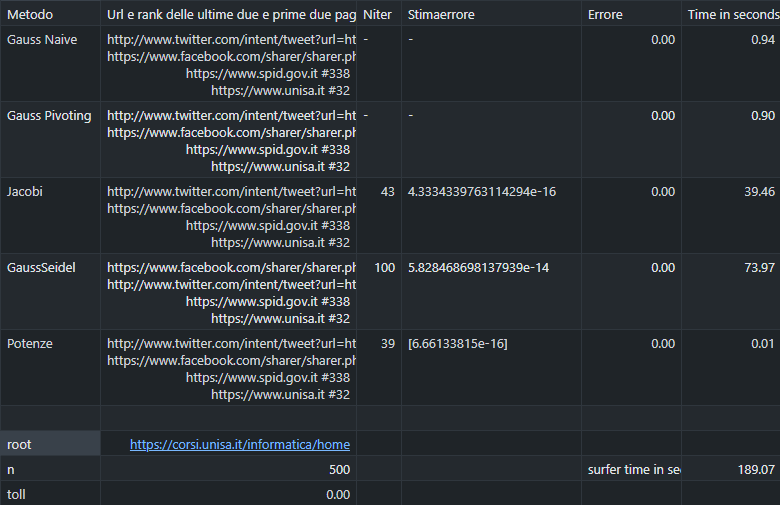



---

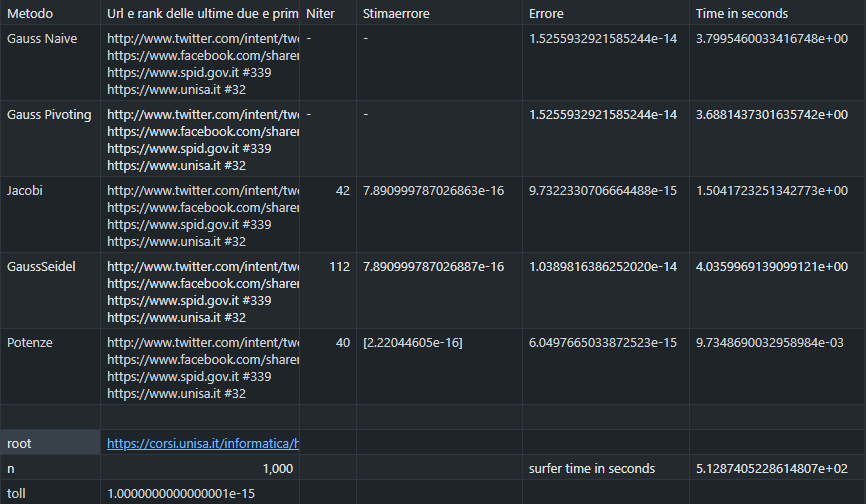



---

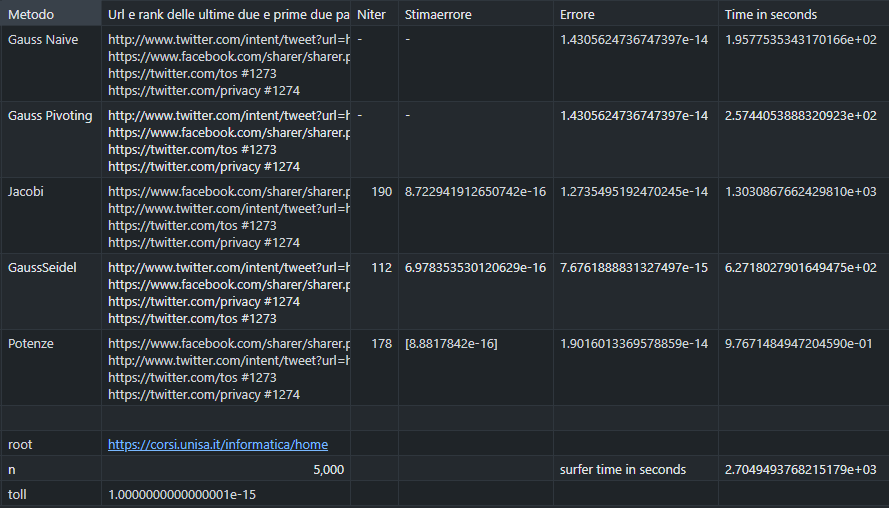



---

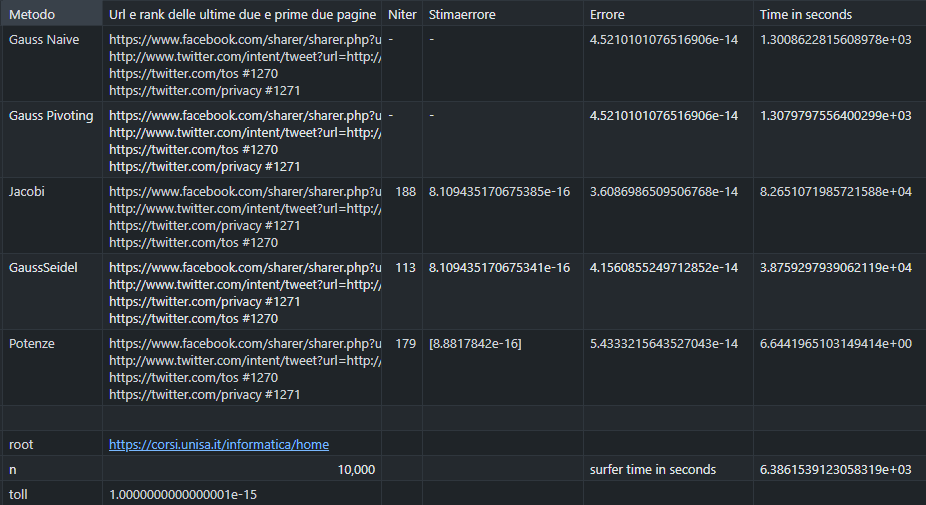

# Riferimenti



* Pagina e-learning del Corso di **Calcolo Scientifico**, Prof Dajana Conte, Università degli Studi di Salerno 
* **Modelli e algoritmi per il calcolo numerico**, di Giovanni Monegato
* **Google's PageRank and Beyond: The Science of Search Engine Rankings**, di Amy N. Langville, Carl D. Meyer
* https://disi.unitn.it/~lissandrini/pdf/SI/SI.04-Internet.pdf
* https://www.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/37976/versions/7/previews/surfer.m/index.html
* https://ahrefs.com/blog/it/google-pagerank/




